In [71]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import gc
import re

from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [66]:
%%time
# Load BES Panel for Wave 8
BES_Panel = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.3.dta")
#(31409, 733)

# BES_Panel = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.6.dta")

print( BES_Panel.shape )

(31409, 733)
Wall time: 13.4 s


In [75]:
# Select only respondents from England who answer Stay/Remain to euVote
England = (BES_Panel["country"]=="England").values
print ( "respondents not from England: ", sum(BES_Panel["country"]!="England") )
Remain  = (BES_Panel["euRefVote"].cat.codes==0).values
Leave   = (BES_Panel["euRefVote"].cat.codes==1).values
print ( "respondents not Remain/Leave: ", len(BES_Panel[~(Remain | Leave)]) )
BES_reduced = BES_Panel[England & (Remain | Leave)]
print( BES_reduced.shape )

respondents not from England:  11944
respondents not from England:  2344
(17979, 733)


In [67]:
# null_corr = BES_null.corr()
# a = null_corr.sum()
# full_list = a[a.isnull()].index
# null_list = a[a.notnull()].index
# null_corr = BES_null[null_list].corr()
# null_corr.stack().value_counts()
# BES_Panel["coverage"] = BES_Panel.isnull().mean(axis=1)
# BES_Panel.corr()["coverage"].sort_values()
# BES_cats = BES_Panel[ BES_Panel.columns[ BES_Panel.dtypes=="category" ] ].apply(lambda x: x.cat.codes)
# BES_cats["coverage"] = BES_Panel["coverage"]
# BES_cats.corr()["coverage"].sort_values()

In [72]:
%%time
# changing the order of some sets of categories
change_cat_dict = {"Bad time to buy|Good time to buy|Neither good nor bad time to buy|Don't know": ["Bad time to buy",
                                                                                                    "Neither good nor bad time to buy",
                                                                                                    "Good time to buy",
                                                                                                    "Don't know"],
                   "Larger|Smaller|About the same|Don't know": ["Larger", "About the same", "Smaller"],
                   "Yes|No|99.0":       ['No', 'Yes', '99.0'],
                   "Yes|No|Don't know": ['No', 'Yes', "Don't know"],
                   "Yes|No" :           ['No', 'Yes'],
                   "Yes, voted|No, did not vote|Donâ??t know" : ['No, did not vote', 'Yes, voted', 'Donâ??t know'],
                   "Yes, voted|No, did not vote|Don?t know"   : ['No, did not vote', 'Yes, voted', 'Don?t know'],                   
                   "I would/will not vote|Leave the EU|Stay/remain in the EU|Don't know": ['Stay/remain in the EU',
                                                                                           'Leave the EU', 'I would/will not vote', "Don't know"],
                   "Mainly leave|Mainly remain|Fairly evenly divided|Don't know": ["Mainly remain",
                                                                                   "Fairly evenly divided", "Mainly leave", "Don't know"],
                   'An individual share in a company|A portfolio of different company shares|The risk is the same|Don\x92t know|Prefer not to say':
                       ['An individual share in a company', 'The risk is the same', 'A portfolio of different company shares'],
                   "No, I have never been a member|Yes, I am a member of a party|I am not a member now but I used to be|Don't know":
                       ['No, I have never been a member', 'I am not a member now but I used to be', 'Yes, I am a member of a party', "Don't know"],
                   "Never or practically never|Less often than once a year|Less often but at least once a year|Less often but at least twice a year|Less often but at least once a month|Less often but at least once in two weeks|Once a week or more|Varies too much to say|I am not religious|Don't know": ['I am not religious', 'Never or practically never', 'Less often than once a year', 'Less often but at least once a year', 'Less often but at least twice a year', 'Less often but at least once a month', 'Less often but at least once in two weeks', 'Once a week or more']
                  }

                   
Weasel_answers = ["Don't know", 'Do\x92t know', 'Dont know', 'Donât know', 'Don??t know',
                  "Prefer not to say", "Prefer not to answer", "Refused", "Unknown",
                  "Neither", "Other", "I would/will not vote", "Will not vote",
                  "I would not vote", "It depends", "Other",
                  "Don’t follow politics on Facebook", "Don't follow politics on twitter",
                  "Yes, other", "Haven't thought about it",
                  "There wasn't a local election in my area", "No, haven't received it",
                  "I don't know what was negotiated", "I never received a response",
                  "There are not local elections in my area", "Can't remember",
                  "Varies too much to say", "Will not state a choice",
                  "All leaders equally good", "They are not eligible to vote",
                  "There are not local elections in my area"]

Weasel_number_answers = [ "9999.0", "997.0", "222.0", "99.0", "0.0" ]

# ADD
# 9999.0
# 99.0 - unfortunately, it also appears in some numerical answers
# Probably need to have a separate check - e.g. is the preceding category "98.0"/"98"

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!


## define 'de_Weasel' function to remove Weasel Words from lists of options
## ie. "Yes|No|Don't know" -> "Yes|No"

Weasel_answers = ["Don't know", 'Don?t know', 'Donâ??t know', 'Do\x92t know', 'Dont know', 'Donât know', "Prefer not to say", "Prefer not to answer", "Refused", "Unknown", "Neither", "Other", "I would/will not vote", "Will not vote", "No - not decided", "I would not vote", "It depends", "Other", "Don’t follow politics on Facebook", "Don't follow politics on twitter", "9999.0", "997.0", "222.0", "Yes, other", "Haven't thought about it", "There wasn't a local election in my area", "No, haven't received it", "I don't know what was negotiated", "I never received a response", "There are not local elections in my area", "Can't remember", "Varies too much to say" ]

# non-answer answers
Weasel_set = set(Weasel_answers) # gets rid of duplicates!

# remove weasel phrases
def de_weasel(ques): 

    return "|".join( [x for x in ques.split("|") if x not in Weasel_answers] )

# reorder categories
def re_order(ques):
    if ques in change_cat_dict.keys():
        return "|".join( change_cat_dict[ques] )
    else:
        return ques

def de_num_el(el):
    if el.isdigit():
        el = "%.1f" % int( el )
    return el

def de_number(ques):
    return "|".join( [de_num_el(x) for x in ques.split("|")] )

def de_num(ques):
    return [de_num_el(x) for x in ques]

def floatable(flt):
    try:
        float(flt)
        return True
    except:
        return False

# Weasel_number_answers
# Remove 'weasel' numbers
# but only if they are the last element
# or not the last element, but the next is not a number
# to avoid catching parts of sequential numerical categories
def de_weasel_numbers(ques):
    el_list = ques.split("|")
    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return "|".join( [x for x in el_list if x not in remove_list] )


# version to act directly on cat.categories array
def de_weasel_nums(el_list):

    el_list_len = len(el_list)
    remove_list = []
    for el_pos in range( 0, el_list_len ):
        if el_list[el_pos] in Weasel_number_answers:
            # last element, or not last element but next element is a not a number
            if el_pos==(el_list_len-1) or not floatable(el_list[el_pos+1]):
                remove_list.append(el_list[el_pos])

    return remove_list

# s.cat.rename_categories([1,2,3])
# EUContactRemainConW8|EUContactRemainLabW8|EUContactRemainLDW8|
# EUContactRemainSNPW8|EUContactRemainPCW8|EUContactRemainUKIPW8|
# EUContactRemainGreenW8|EUContactRemainOthW8|EUContactRemainNoneW8|
# EUContactRemainDKW8|EUContactLeaveConW8|EUContactLeaveLabW8|
# EUContactLeaveLDW8|EUContactLeaveSNPW8|EUContactLeavePCW8|
# EUContactLeaveUKIPW8|EUContactLeaveGreenW8|EUContactLeaveOthW8|
# EUContactLeaveNoneW8|EUContactLeaveDKW8

# pattern match "EUContact*****W8"
# debateOneWatchW8|debateTwoWatchW8

# "1.0|2.0|99.0" -> 

# euRefVoteSqueezeW7 "Will not vote|Yes - Leave|Yes - Remain|No - not decided"
#    -> Stay/remain in the EU|Leave the EU|I would/will not vote|Don't know
#    HMM - RENAME AND REORDER!

# miieuW7
# "Issue stated|Nothing|Don't know" -> "Issue stated|None|Don't know"
# MIIEUW8
# "1.0|Nothing|Don't know" -> "Issue stated|None|Don't know"
# partyIdEUW7|partyIdEUW8
# "Mainly leave|Mainly remain|Fairly evenly split|Don't know" -> "Mainly remain|Fairly evenly divided|Mainly leave|Don't know"
#    HMM - RENAME AND REORDER!

# 1. campaignVisionYesW3|campaignVisionNoW3, govtNatSecuritySuccessW4
# Very unsuccessful|Fairly unsuccessful|Neither successful nor unsuccessful|Fairly successful|Very successful|Don't know
# Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know

# Fairly <-> Somewhat

# 2. euroTurnoutW1, scotReferendumTurnoutW1|scotReferendumTurnoutW2|welshTurnoutW7|scotTurnoutW7, turnoutUKGeneralW1|turnoutUKGeneralW2|turnoutUKGeneralW3|turnoutUKGeneralW4|turnoutUKGeneralW5|euRefTurnoutW7|euRefTurnoutW8
# Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know
# Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know
# There are not local elections in my area
    #|Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know
# Very unlikely that I will vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I will vote|Don't know

# "Very unlikely that I vote", "Very unlikely that I would vote" ->  "Very unlikely that I will vote" 

rename_cat_dict = {"North East|North West": [ "No", "Yes" ],
                   "1.0|2.0|99.0": ["No", "Yes", "99.0"],
                   "Will not vote|Yes - Leave|Yes - Remain|No - not decided": ['I would/will not vote', 'Leave the EU',
                                                                               'Stay/remain in the EU', "Don't know"],
                   "Issue stated|Nothing|Don't know":  ['Issue stated', 'None', "Don't know"],
                   "1.0|Nothing|Don't know":           ['Issue stated', 'None', "Don't know"],
                   "a|b|C1|C2|d|e|Refused|Unknown" : ['A', 'B', 'C1', 'C2', 'D', 'E', 'Refused', 'Unknown'],
                   "Mainly leave|Mainly remain|Fairly evenly split|Don't know": ['Mainly leave',
                                                                                 'Mainly remain', 'Fairly evenly divided', "Don't know"],
                   "Very unsuccessful|Somewhat unsuccessful|Neither successful or unsuccessful|Somewhat successful|Very successful|Don't know": ['Very unsuccessful',
                        'Fairly unsuccessful', 'Neither successful nor unsuccessful', 'Fairly successful', 'Very successful', "Don't know"],
                   "Very unlikely that I vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I vote|Don't know": ['Very unlikely that I will vote',
                     'Fairly unlikely', 'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   "Very unlikely that I would vote|Fairly unlikely|Neither likely nor unlikely|Fairly likely|Very likely that I would vote|Don't know": ['Very unlikely that I will vote',
                     'Fairly unlikely', 'Neither likely nor unlikely', 'Fairly likely', 'Very likely that I will vote', "Don't know"],
                   }


def re_name(ques):
    if ques in rename_cat_dict.keys():
        return "|".join( rename_cat_dict[ques] )
    else:
        return ques


ignore_list = ['approveEUW2',
               'whichPartiesHelped_99W6',
               'partyContactGrnW1',
               'partyContactGrnW2',
               'reasonNotRegistered_noneW2',
               'partyContactGrnW3',
               'reasonNotRegistered_noneW3',
               'reasonNotRegistered_noneW4',
               'reasonNotRegistered_noneW6',
               'reasonNotRegistered_noneW7',
               'reasonNotRegistered_noneW8',
               'partyContactSNPW1',
               'partyContactSNPW2',
               'changeIssue1W9',
               'conLeaderLikeW9'
              ]

#- approveEUW2 'Strongly disapprove|Disapprove|Don't know' - should be "approve|disapprove|don't know"??? NOT SURE (distribution weird)
#- whichPartiesHelped_99W6 - answer set = ["No"]
#- partyContactGrnW1 ... reasonNotRegistered_noneW8 answer set = ["No", "Don't know"]
# -partyContactSNPW1, partyContactSNPW2 - answer set = ["Don't know"]
# -changeIssue1W9|conLeaderLikeW9 - answer set = ["No formal qualifications"]

## define 'prune' function to prune wave indicators and return question stubs
## ie. "ptvConW1|ptvLabW1" -> "ptvCon|ptvLab"

def prune(x):
    
    y= []
    for el in x.split("|"):
        match_attempt = re.match('(\w*?)_?(W[0-9]+)+' , el )   
        if match_attempt:
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)

               
def prune2(x):
    
    y= []
    for el in x.split("|"):
        match_attempt = re.match('(\w*?)_?[0-9]+' , el )   
        if match_attempt:
            el = match_attempt.groups()[0]
        y.append(el)
    # should we ditch identical repeats?
    # return "|".join(set(y)) NEEDS TO BE TESTED
    return "|".join(y)
#variable_categories

Wall time: 0 ns


In [76]:
variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

# flipping list
var_cat_dict = dict()
for typ in [1,2,3,4,5,6]:
    e = variable_categories[variable_categories.type==typ]["column_name"].values
    var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
# dictionary comprehension to prune column-names to wave non-specific stubs
# list(set()) gets rid of repetitions
var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}

In [77]:
var_type = pd.DataFrame(columns = ['type'] )
# df = DataFrame(columns=('lib', 'qty1', 'qty2'))

missing_col_names = []

for col in BES_reduced.columns:
    dt =  BES_reduced[col].dtype.name # data type
    not_found = False
    if ( dt!='category' ) and ( dt!='float64' ):
        var_type.loc[col] = -1
    
    elif ( dt=='float64' ) and (col in ['personality_agreeableness',
                                        'personality_conscientiousness',
                                        'personality_extraversion',
                                        'personality_neuroticism',
                                        'personality_openness',
                                        'mapNamesW3',
                                        'riskScaleW8']):
        var_type.loc[col] = 0

    elif ( dt=='float64' ):
        var_type.loc[col] = -1

    elif ( dt=='category' ):
        not_found = True
        for typ in [1,2,3,4,5,6]:
            if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                var_type.loc[col] = typ
                not_found = False

    if not_found == True:
  #      print("what's up with this? " + col, prune2( prune(col) ) )
        missing_col_names.append(col)
var_type["type"] = var_type["type"].astype("int8")
missing_col_names

[]

In [82]:
if missing_col_names:

    updated_variable_categories = variable_categories.copy()

    # question	frequency	question_length	question_options	column_name	type

    for i in missing_col_names:
        str_list = [ str(cat) for cat in BES_reduced[i].cat.categories ]
        joined_list = "|".join(str_list)
        match  = (joined_list == updated_variable_categories["question"])
        # print(i, " : " , "|".join(str_list ), " : ", len(str_list) )
        if match.any(): # answer set already in records
            index = updated_variable_categories[match].index
            if len(index)>1: # answer set ("question") index should be unique!
                raise ValueError('answer set ("question") index should be unique!')

            # add column name and increase frequency
            updated_variable_categories.loc[index,"frequency"] = updated_variable_categories.loc[index,"frequency"]+1
            current_list_col_names = updated_variable_categories.loc[index,"column_name"].values[0].split("|")
            current_list_col_names.append(i)
            updated_variable_categories.loc[index,"column_name"] = "|".join( current_list_col_names )
        else: # answer set not already in records - add new line to dataframe
            df = pd.DataFrame([],  columns = updated_variable_categories.columns )

            df.loc[0] = [updated_variable_categories.shape[0],
                         joined_list,
                         1,
                         len(joined_list),
                         len(str_list),
                         i,-1]
            updated_variable_categories = updated_variable_categories.append(df, ignore_index=True)

    variable_categories = updated_variable_categories
    updated_variable_categories.to_csv("question_categories_correct_updatesneeded!.csv", encoding = "ISO-8859-1")
    
    # rerun after updating list!
    
    #variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

    # flipping list
    var_cat_dict = dict()
    for typ in [1,2,3,4,5,6]:
        e = variable_categories[variable_categories.type==typ]["column_name"].values
        var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]

    # dictionary comprehension to prune column-names to wave non-specific stubs
    # list(set()) gets rid of repetitions
    var_cat_dict_pruned   = {k: list(set([prune(x)  for x in v])) for k, v in var_cat_dict.items()}
    var_cat_dict_pruned_2 = {k: list(set([prune2(x) for x in v])) for k, v in var_cat_dict_pruned.items()}        
        
    var_type = pd.DataFrame(columns = ['type'] )
    missing_col_names = []

    for col in BES_reduced.columns:
        dt =  BES_reduced[col].dtype.name # data type
        not_found = False
        if ( dt!='category' ) and ( dt!='float64' ):
            var_type.loc[col] = -1

        elif ( dt=='float64' ) and (col in ['personality_agreeableness',
                                            'personality_conscientiousness',
                                            'personality_extraversion',
                                            'personality_neuroticism',
                                            'personality_openness',
                                            'mapNamesW3',
                                            'riskScaleW8']):
            var_type.loc[col] = 0

        elif ( dt=='float64' ):
            var_type.loc[col] = -1

        elif ( dt=='category' ):
            not_found = True
            for typ in [1,2,3,4,5,6]:
                if prune2( prune(col) ) in var_cat_dict_pruned_2[typ]:
                    var_type.loc[col] = typ
                    not_found = False

        if not_found == True:
            raise ValueError('Values still missing second time around! ', col)
    var_type["type"] = var_type["type"].astype("int8")

In [79]:
# BES_Panel['personality_agreeableness'].value_counts()

# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_name)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_order)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel_numbers)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_number)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel)

In [131]:
# %%time
BES_numeric = BES_reduced.copy()
pos = 0
for col in BES_numeric:
    print(100*pos/len(BES_numeric.columns))
    pos = pos + 1
    
    if col not in var_type["type"].index:
        print(col, " not in var_type")
        continue
    typ = var_type["type"][col]
    if (typ == -1) | (typ == 4) | (typ == 3) | (col =="id") | (typ==0) | (col in ignore_list): # skip
        continue
        #BES_numeric.drop(col,axis=1,inplace=True)
        
    #print(col)
         
    
    # force all category elements into strings
    BES_numeric[col].cat.rename_categories( BES_numeric[col].cat.categories.map(str), inplace=True )
    
    # rename categories
    
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in rename_cat_dict.keys():
        BES_numeric[col].cat.rename_categories(  rename_cat_dict[join_list], inplace=True )
    # update join_list!
    
    # reorder categories
    join_list = "|".join( BES_numeric[col].cat.categories )
    if join_list in change_cat_dict.keys():
#         print(col)
#         print(join_list)
#         print(change_cat_dict[join_list])
        BES_numeric[col].cat.reorder_categories( change_cat_dict[join_list], inplace=True )    
    
    # de_weasel numbers
    BES_numeric[col].cat.remove_categories( de_weasel_nums( BES_numeric[col].cat.categories ), inplace=True )
    
    # set all digits to floating point format, one decimal place
    BES_numeric[col].cat.rename_categories( de_num( BES_numeric[col].cat.categories ), inplace=True )
                                          
    # de_weasel                                   
    BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
                    
    
    if (typ==1) | (typ==2) | (typ==5): # more or less ordinal, replace string categories with 
        BES_numeric[col] = BES_numeric[col].cat.codes
        BES_numeric[col] = BES_numeric[col].astype('float64')
          
        
    elif (typ==6):
        BES_numeric[col] = BES_numeric[col].astype('float64')
      
        
#     elif (typ == 2):
#         new_cat_order = change_cat_dict["|".join(BES_numeric[col].cat.categories)]
#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         BES_numeric[col].cat.reorder_categories( new_cat_order, inplace=True )

#         BES_numeric[col] = BES_numeric[col].cat.codes
# #        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan  
    
#     elif (typ == 5) | (typ == 1): # (typ == 1) | 
#         # remove weasel categories
#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         # change to numbers!
#         BES_numeric[col] = BES_numeric[col].cat.codes
# #        BES_numeric.loc[ BES_numeric[col]==-1, col ] = np.nan
        

#     elif (typ == 6):

#         BES_numeric[col].cat.remove_categories( BES_numeric[col].cat.categories.intersection(Weasel_set), inplace=True )
#         BES_numeric[col] = BES_numeric[col].astype('float64')

# types
# -1 - anything not a category or one of the below floats
# 0 - personality measures (in steps of .5?),'mapNamesW3','riskScaleW8'
# 1 - linear category, just use  (some made linear by dropping "Weasel_answers")
# 2 - categories need to be modified - order changed
# 3 - set of non-ordered options
# 4 - indirect variables - did someone fill something in in the free text box or not?
# 5 - categories need to modified - things removed
# 6 - categories are integers - should maybe be transformed directly into numbers (mostly "how much money do people need minimum/well off"?)


# load question_categories_correct.csv
# sanity check by type!
# turn into list of variables by type
# 1, 5 handled the same way -> cat.codes
# 6 -> int()
# 4 ignored
# 3 ignored for now (-> vectorized?)
# 2 direct modification




0.0
0.1364256480218281
0.2728512960436562
0.4092769440654843
0.5457025920873124
0.6821282401091405
0.8185538881309686
0.9549795361527967
1.0914051841746248
1.2278308321964528
1.364256480218281
1.500682128240109
1.6371077762619373
1.7735334242837653
1.9099590723055935
2.0463847203274215
2.1828103683492497
2.319236016371078
2.4556616643929057
2.592087312414734
2.728512960436562
2.8649386084583903
3.001364256480218
3.1377899045020463
3.2742155525238745
3.4106412005457027
3.5470668485675305
3.6834924965893587
3.819918144611187
3.956343792633015
4.092769440654843
4.229195088676671
4.365620736698499
4.502046384720328
4.638472032742156
4.774897680763984
4.911323328785811
5.04774897680764
5.184174624829468
5.320600272851296
5.457025920873124
5.593451568894952
5.729877216916781
5.866302864938609
6.002728512960436
6.139154160982264
6.275579809004093
6.412005457025921
6.548431105047749
6.684856753069577
6.8212824010914055
6.957708049113234
7.094133697135061
7.230559345156889
7.3669849931787175
7.

In [133]:
BES_numerics_only = BES_numeric.drop( BES_numeric.columns[~( (var_type["type"]==0) |
                                                             (var_type["type"]==1) |
                                                             (var_type["type"]==2) |
                                                             (var_type["type"]==5) |
                                                             (var_type["type"]==6) ) ], axis=1 )

BES_numerics_only.replace(-1,np.nan, inplace=True)
# gender only column that has no nan -> still an int

In [392]:
# variable_categories = pd.read_csv("question_categories_correct.csv", encoding = "ISO-8859-1")

# # flipping list
# var_cat_dict = dict()
# for typ in [1,2,3,4,5,6]:

#     e = variable_categories[variable_categories.type==typ]["column_name"].values

#     var_cat_dict[typ] = [item for sublist in [i.split("|") for i in e] for item in sublist]
    
# var_cat_dict

In [395]:
# # try to create list of variable 'stubs' without wave signifier
# import re
# # pattern
# # \w*? (non-greedy match all alphanumerics)
# # (\w*?)_?W[0-9]
# # re.match('(\w*?)_?W[0-9]' , 'partyHelpMethod_5_W6' ).groups()[0]

# new_list = []
# for ques in var_cat_dict[1]:
#     question = ques
#     match_attempt = re.match('(\w*?)_?W[0-9]' , ques )   
#     if match_attempt:
#         question = match_attempt.groups()[0]
#     if question not in new_list:
#         new_list.append(question )

# new_list

In [ ]:
# pattern 2
# what about 
# 'fbInfo_1',
# 'fbInfo_2',
# 'fbInfo_3',

# and
#  'euKnow6',
#  'euKnow2',
#  'euKnow1',
#  'euKnow3',
#  'euKnow4',
#  'euKnow5',


In [81]:
# variable_categories["pruned_column_name"] = variable_categories["column_name"].apply(prune)

In [57]:
# variable_categories.to_csv("temp_name.csv")

In [59]:
# test_df = pd.read_csv("temp_name.csv", encoding = "ISO-8859-1")

In [394]:
# variable_categories["de_weaseled_questions"] = variable_categories["question"]
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_name)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(re_order)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel_numbers)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_number)
# variable_categories["de_weaseled_questions"] = variable_categories["de_weaseled_questions"].apply(de_weasel)
# variable_categories["de_weaseled_questions"]

In [396]:
# ## So, I'd like to go through the entire list of *de_weaseled categories*
# ## and enumerate the unique lists
# ## On the basis that some will be the same post de_weaseling
# ## and some will be the same when you ignore ordering

# unique_count = 0
# unique_list = []

# unique_df = pd.DataFrame( columns = ( "orig_question", "tran_question", "coding", "coding_of_matches" ) ) #to store the semantic coding (/s) of question asssociated with a unique ans set

# for ind_1 in range(0, len(variable_categories["de_weaseled_questions"].index)):
    
#     ques_1 = variable_categories["de_weaseled_questions"][ind_1].encode("ascii", "ignore").decode("utf-8").split("|")
#     ques_orig = ques_1
#     ques_1 = [x.lower() for x in ques_1]
    
#     unique_flag = True
    
#     coding_of_matches = []
    
#     for ind_2 in range(ind_1+1, len(variable_categories["de_weaseled_questions"].index)):
    
#         ques_2 = variable_categories["de_weaseled_questions"][ind_2].encode("ascii", "ignore").decode("utf-8").split("|")
#         ques_2 = [x.lower() for x in ques_2]
#         if ques_1 == ques_2:
# #             print("Same options: ", ind_1, ind_2, ques_1, ques_2)
#             unique_flag = False
#             num_type = variable_categories["type"][ind_2]
#             if num_type not in coding_of_matches:
#                 coding_of_matches.append( num_type )
#         elif set(ques_1) == set(ques_2):
# #             print("Same options, diff order: \n ***********************************\n", ind_1, ind_2, ques_1, ques_2)
#             unique_flag = False
#             num_type = variable_categories["type"][ind_2]
#             if num_type not in coding_of_matches:
#                 coding_of_matches.append( num_type )
            
#     if unique_flag == True:
#         unique_count = unique_count + 1
#         unique_list.append(ques_orig)
        
#     unique_df.loc[ind_1] = [variable_categories["question"][ind_1],
#                             variable_categories["de_weaseled_questions"][ind_1],
#                             variable_categories["type"][ind_1],
#                             coding_of_matches
#                            ]
#     if len( coding_of_matches ) >1:
#         print( [variable_categories["question"][ind_1],
#                             variable_categories["de_weaseled_questions"][ind_1],
#                             variable_categories["type"][ind_1],
#                             coding_of_matches
#                            ] )
        
# print("unique_count: ", unique_count)

In [397]:
# unique_list.sort()

# unique_df = pd.DataFrame( [list(map("|".join, unique_list)), list(map(len, unique_list))] ).transpose()
# unique_df.columns = [ 'answer_set', 'num_answers']
# unique_df["answer_set_size"] = unique_df['answer_set'].apply(len)
# unique_df.to_csv("unique_answer_set_list.csv")
# #list(map("|".join, unique_list))
# #list(map(len, unique_list))

# #unique_list.to_csv("unique_answer_set_list.csv")

In [398]:
# # diff ans sets based on original

# list_of_all_col_stubs = []
# for ind in variable_categories["pruned_column_name"].index:
#     list_of_all_col_stubs.append ( variable_categories["pruned_column_name"][ind].split("|") )
# list_of_all_col_stubs

In [399]:
# #pos1 = 0
# stubs_with_diff_ans_sets = []
# for list_pos_1 in range(0,len(list_of_all_col_stubs)):
# #var_list in list_of_all_col_stubs: # for each list of questions by sets of shared answer categories
#     var_list = list_of_all_col_stubs[list_pos_1]
#     for var in set(var_list): # for each *unique* question_stub in those lists
#         #pos2 = 0
#         for list_pos_2 in range(list_pos_1+1,len(list_of_all_col_stubs)):
#         # comp_var_list in list_of_all_col_stubs: # see if it is in other lists
# #             if comp_var_list == var_list: # excepting its original list
# #                 continue
#             if var in list_of_all_col_stubs[list_pos_2]:
#                 print (list_pos_1, var, list_pos_2)
#                 if var not in stubs_with_diff_ans_sets:
#                     stubs_with_diff_ans_sets.append(var)
                
# #             pos2 = pos2 + 1
# #     pos1 = pos1+1

In [400]:
# stubs_with_diff_ans_sets
# temp = stubs_with_diff_ans_sets
# #difficult = ['partyContact', 'EUContact']
# [x for x in temp if x.find("partyContact") and x.find('EUContact') ]
# # partyContact
# # EUContact

In [ ]:
# SOME WEIRDNESS NEEDS FIXING

# 161	Don't know	2	10	1	partyContactSNPW1|partyContactSNPW2	4
# 185	1	1	3	1	locusControlW8	4
# 265	No	1	2	1	whichPartiesHelped_99W6	4

# These questions show up as having *only one answer option* 



In [ ]:
#################################### MISSING VALUES ###################################

In [148]:
# counts = BES_numerics_only.count() # super slow!
# counts_by_individuals = BES_numerics_only.count(axis=1) # lets see
# f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
# axarr[0].hist(counts,bins=50)
# axarr[1].hist(counts_by_individuals,bins=50)

In [149]:
BES_numerics_only.shape

(17979, 563)

In [150]:
# BES_Panel["coverage"] = BES_Panel.count(axis=1)
# BES_Panel

In [139]:
corr_mat = BES_Panel.corr()

In [140]:
# BES_Panel["coverage"][  BES_Panel["wave9"]==1 ].mean()

436.55636419944256

In [141]:
# BES_Panel["wave9"].sum()

25832

In [142]:
# BES_Panel.shape

(31409, 734)

In [143]:
# BES_Panel["coverage"].mean()

411.68770097742686

(array([    2.,     3.,     5.,     2.,     5.,     4.,    10.,    13.,
            6.,     9.,    14.,    30.,    27.,    22.,    30.,    28.,
           36.,    35.,    53.,    57.,    65.,    75.,    92.,    90.,
          128.,   131.,   176.,   198.,   291.,   331.,   475.,   556.,
          696.,   948.,  1246.,  1876.,  1771.,  1534.,  1060.,   882.,
          734.,   608.,   286.,   138.,    82.,    57.,    29.,    11.,
            6.,     4.]),
 array([  36.  ,   43.14,   50.28,   57.42,   64.56,   71.7 ,   78.84,
          85.98,   93.12,  100.26,  107.4 ,  114.54,  121.68,  128.82,
         135.96,  143.1 ,  150.24,  157.38,  164.52,  171.66,  178.8 ,
         185.94,  193.08,  200.22,  207.36,  214.5 ,  221.64,  228.78,
         235.92,  243.06,  250.2 ,  257.34,  264.48,  271.62,  278.76,
         285.9 ,  293.04,  300.18,  307.32,  314.46,  321.6 ,  328.74,
         335.88,  343.02,  350.16,  357.3 ,  364.44,  371.58,  378.72,
         385.86,  393.  ]),
 <a list of 50 Pa

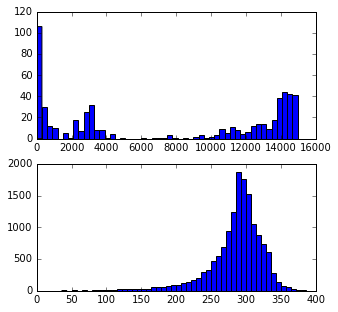

In [151]:
counts = BES_numerics_only[BES_reduced["wave9"]==1 ].count() # super slow!
counts_by_individuals = BES_numerics_only[BES_reduced["wave9"]==1 ].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [ ]:
# Suspicious answer coverage patterns
# (1) people who don't answer much (hence positive correlation with people answering 'polAttention               0.485386')
# (2) people who answer *too much* (hence positive correlation with 'EUContactLeaveSNP')

# suggests a strategy to try to fish out those people by including dumb questions to find people who've stopped paying attention

In [ ]:
# drop people who are coverage outliers
# say top and bottom 5%



In [164]:
thresh = .05
outlier_people = BES_red[( BES_red["coverage"]>BES_red["coverage"].quantile(1-thresh) ) | 
                         ( BES_red["coverage"]<BES_red["coverage"].quantile(  thresh) ) ].index
inlier_people  = BES_red[( BES_red["coverage"]<BES_red["coverage"].quantile(1-thresh) ) & 
                         ( BES_red["coverage"]>BES_red["coverage"].quantile(  thresh) ) ].index

(array([  74.,   28.,   47.,   43.,   73.,   59.,   49.,   68.,   60.,
          91.,   73.,   98.,   74.,   77.,  148.,   97.,  181.,  141.,
         135.,  214.,  156.,  259.,  188.,  300.,  208.,  242.,  403.,
         303.,  508.,  348.,  592.,  432.,  487.,  755.,  524.,  760.,
         487.,  498.,  635.,  401.,  474.,  307.,  428.,  263.,  259.,
         309.,  214.,  327.,  202.,  271.]),
 array([ 211.  ,  213.42,  215.84,  218.26,  220.68,  223.1 ,  225.52,
         227.94,  230.36,  232.78,  235.2 ,  237.62,  240.04,  242.46,
         244.88,  247.3 ,  249.72,  252.14,  254.56,  256.98,  259.4 ,
         261.82,  264.24,  266.66,  269.08,  271.5 ,  273.92,  276.34,
         278.76,  281.18,  283.6 ,  286.02,  288.44,  290.86,  293.28,
         295.7 ,  298.12,  300.54,  302.96,  305.38,  307.8 ,  310.22,
         312.64,  315.06,  317.48,  319.9 ,  322.32,  324.74,  327.16,
         329.58,  332.  ]),
 <a list of 50 Patch objects>)

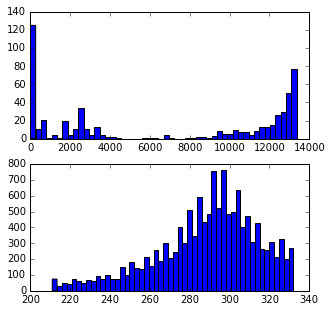

In [165]:
counts = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people].count() # super slow!
counts_by_individuals = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=50)
axarr[1].hist(counts_by_individuals,bins=50)

In [168]:

mostly_filled_out = counts[counts> (counts.max()/3)].index

(array([    3.,     8.,     6.,    27.,    65.,   137.,   156.,   184.,
          238.,   295.,   467.,   528.,   638.,   804.,  1081.,  1726.,
         2030.,  2278.,  2018.,   681.]),
 array([ 171. ,  177.2,  183.4,  189.6,  195.8,  202. ,  208.2,  214.4,
         220.6,  226.8,  233. ,  239.2,  245.4,  251.6,  257.8,  264. ,
         270.2,  276.4,  282.6,  288.8,  295. ]),
 <a list of 20 Patch objects>)

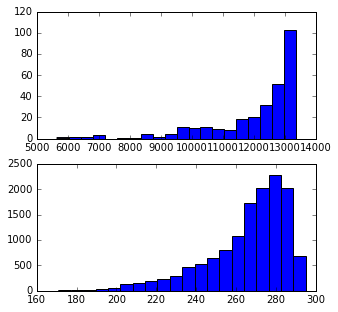

In [173]:
counts = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people][mostly_filled_out].count() # super slow!
counts_by_individuals = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people][mostly_filled_out].count(axis=1) # lets see
f, axarr = plt.subplots( 2 ,figsize=(5, 5) )
axarr[0].hist(counts,bins=20)
axarr[1].hist(counts_by_individuals,bins=20)

In [175]:
BES_min = BES_numerics_only[BES_reduced["wave9"]==1 ].loc[inlier_people][mostly_filled_out]

In [177]:
BES_min.isnull().sum().sum()/(BES_min.shape[0]*BES_min.shape[1])

0.099031984077684668

In [178]:
BES_min.shape

(13370, 295)

In [179]:
corr_mat = BES_min.corr()

In [592]:
# BES_latest = pd.read_stata("../BES_analysis_data/BES2015_W8_v1.6.dta") 

In [185]:
# create lower triangle - diag mask
col_vars = len( corr_mat )
df = pd.DataFrame( np.arange(col_vars*col_vars).reshape(col_vars,col_vars) )
mask = np.ones(df.shape,dtype='bool')
mask[np.triu_indices(len(df))] = False

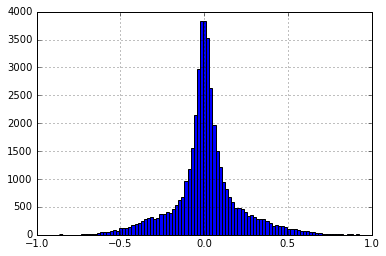

In [267]:
corr_mat.mask(~mask).stack().hist(bins=100)

In [292]:
thresh = .05
x = ( ( corr_mat>(1-thresh) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_min[a].notnull().mean(), BES_min[b].notnull().mean() ) )

x = ( ( corr_mat<(thresh-1) ) &mask ).values.nonzero()
# z = list( zip(corr_mat.columns[x[0]],corr_mat.columns[x[1]]) )
# z
for i in range( 0,len(x[0]) ):
    a = corr_mat.columns[ x[0][i] ]
    b = corr_mat.columns[ x[1][i] ]
    print( ( a,b,corr_mat[a][b], BES_min[a].notnull().mean(), BES_min[b].notnull().mean() ) )    

('euRefVoteUnsqueeze', 'euRefVote', 1.0, 0.81802543006731487, 1.0)
('euRefVote2', 'euRefVote', 1.0, 0.86499626028421839, 1.0)
('euRefVote2', 'euRefVoteUnsqueeze', 1.0, 0.86499626028421839, 0.81802543006731487)
('euIDW9', 'euRefVoteW9', 0.96840982616968241, 0.95527299925205689, 0.96178010471204189)
('ageGroup', 'age', 0.97385351485015925, 0.74652206432311141, 1.0)
('Age', 'age', 0.99878700446253232, 1.0, 1.0)
('Age', 'ageGroup', 0.97524849047393303, 1.0, 0.74652206432311141)
('profile_turnout_2015', 'voted2015', 1.0, 0.9970082273747195, 0.91585639491398652)


In [295]:
high_corr_drop_list = ['euRefVoteUnsqueeze', 'euRefVote2', 'ageGroup', 'age', 'voted2015' ]

In [293]:
# Age - age as of January 2014


In [297]:
BES_min.drop(high_corr_drop_list,axis=1, inplace=True)

In [298]:
BES_min.shape

(13370, 290)

In [300]:
BES_min.to_hdf("BESW8min.hdf", "BESW8min")

In [301]:
BES_new = pd.read_hdf("BESW8min.hdf")

In [302]:
BES_new

,partyIdEU,partyIdEUretroW9,postalapply,euRefTurnout,euRefVote,euRefCertainty,euRefInterest,euRefExpectation,euRefFinal,britishness,...,schoolChildrenInHousehold,sickOrElderlyInHousehold,noDependentsInHousehold,prevJob,selfOccStatus,selfOccStatusLast,edlevel,profile_turnout_2015,lr_scale,al_scale
0,2.0,0.0,0.0,4.0,1.0,6.0,3.0,54.0,1.0,2.0,...,0.0,0.0,1.0,1.0,NaN,1.0,NaN,0.0,1.0,16.0
1,1.0,1.0,0.0,4.0,1.0,6.0,3.0,59.0,1.0,4.0,...,0.0,0.0,1.0,1.0,0.0,0.0,4.0,0.0,15.0,12.0
5,2.0,1.0,0.0,4.0,1.0,4.0,3.0,49.0,1.0,6.0,...,0.0,0.0,1.0,NaN,1.0,NaN,4.0,0.0,12.0,12.0
10,NaN,2.0,0.0,4.0,0.0,6.0,3.0,36.0,NaN,3.0,...,0.0,0.0,1.0,NaN,1.0,NaN,3.0,0.0,6.0,15.0
11,NaN,0.0,NaN,4.0,1.0,6.0,3.0,50.0,1.0,6.0,...,0.0,0.0,1.0,1.0,NaN,1.0,2.0,0.0,18.0,18.0
12,1.0,1.0,0.0,4.0,1.0,5.0,3.0,49.0,1.0,5.0,...,0.0,0.0,1.0,1.0,NaN,1.0,2.0,0.0,5.0,13.0
13,2.0,1.0,0.0,4.0,1.0,6.0,2.0,50.0,0.0,6.0,...,0.0,0.0,1.0,1.0,NaN,1.0,2.0,0.0,13.0,15.0
14,2.0,NaN,0.0,4.0,1.0,6.0,3.0,41.0,0.0,0.0,...,0.0,0.0,1.0,NaN,0.0,NaN,2.0,0.0,13.0,17.0
17,NaN,NaN,1.0,NaN,1.0,NaN,2.0,53.0,0.0,5.0,...,0.0,0.0,1.0,1.0,1.0,1.0,NaN,0.0,12.0,14.0
18,2.0,2.0,0.0,4.0,1.0,6.0,3.0,58.0,0.0,5.0,...,0.0,1.0,0.0,1.0,NaN,1.0,4.0,0.0,2.0,19.0
